<a href="https://colab.research.google.com/github/OmerrYildirim/HuaweiProject/blob/main/Huawei_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
import shutil
import os
import kagglehub

src_path = kagglehub.dataset_download("mohammedjaveed/loveda-dataset")
dst_path = "/content/loveda-dataset"

# Kopyala (veya taşı)
if not os.path.exists(dst_path):
    shutil.copytree(src_path, dst_path)

In [5]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import os

class LoveDADataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, mask_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.mask_transform = mask_transform
        self.image_filenames = sorted(os.listdir(image_dir))  # ensure matching order
        self.mask_filenames = sorted(os.listdir(mask_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_filenames[idx])

        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)  # do not convert to RGB

        if self.transform:
            image = self.transform(image)
        if self.mask_transform:
            mask = self.mask_transform(mask)

        mask = mask.squeeze(0)
        mask = mask.long()

        mask[mask == 7] = 0  # Geçersiz sınıfı düzelt


        return image, mask


In [6]:
import torchvision.transforms as T

image_transform = T.Compose([
    T.Resize((256, 256)),  # Resmi 256x256 yapar (yükseklik, genişlik)
    T.ToTensor(),          # Tensor'a çevirir ve normalize eder [0,1]
])

mask_transform = T.Compose([
    T.Resize((256, 256), interpolation=T.InterpolationMode.NEAREST),  # Maskeyi de resize et (etiket bozulmasın diye nearest)
    T.PILToTensor(),  # Tensor'a çevirir (normalize etmez)
])



| Tür                  | Açıklama                                           | Avantajları                                | Dezavantajları                                | Kullanım Alanları                 |
| -------------------- | -------------------------------------------------- | ------------------------------------------ | --------------------------------------------- | --------------------------------- |
| **Nearest Neighbor** | En yakın pikselin değerini aynen alır.             | Çok hızlı, sınıf maskeleri için ideal.     | Kenarlar keskin olabilir, görüntü pürüzlü.    | Segmentasyon maskeleri, etiketler |
| **Bilinear**         | Komşu 4 pikselin ağırlıklı ortalamasını alır.      | Daha yumuşak sonuçlar, doğal görünüm.      | Maskelerde sınıf karışıklığı olabilir.        | Fotoğraflar, genel görüntüler     |
| **Bicubic**          | Komşu 16 pikselin karmaşık ağırlıklı ortalaması.   | Daha yumuşak, keskin ve kaliteli sonuçlar. | Daha yavaş, maskelerde hataya neden olabilir. | Fotoğraf büyütme, baskı işleri    |
| **Lanczos**          | Matematiksel olarak daha karmaşık, yüksek kaliteli | Çok keskin, kaliteli sonuç.                | Hesaplama maliyeti yüksek.                    | Profesyonel görüntü işleme        |


In [19]:
from torch.utils.data import DataLoader, random_split

# Artık sabit path'in var:
image_dir = "/content/loveda-dataset/Train/Train/Urban/images_png"
mask_dir  = "/content/loveda-dataset/Train/Train/Urban/masks_png"

train_dataset = LoveDADataset(image_dir, mask_dir,
                               transform=image_transform,
                               mask_transform=mask_transform)

val_ratio = 0.2
val_size = int(len(train_dataset) * val_ratio)
train_size = len(train_dataset) - val_size

train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_subset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=8, shuffle=False)




In [20]:
import os

mask_dir = '/content/loveda-dataset/Train/Train/Urban/masks_png'
mask_files = sorted(os.listdir(mask_dir))
img_dir = '/content/loveda-dataset/Train/Train/Urban/images_png'
img_files = sorted(os.listdir(img_dir))

# Örnek olarak ilk dosyayı al
first_mask_path = os.path.join(mask_dir, mask_files[0])
print("İncelenecek maske dosyası:", first_mask_path)
first_img_path = os.path.join(img_dir, img_files[0])
print("İncelenecek resim dosyası:", first_img_path)


İncelenecek maske dosyası: /content/loveda-dataset/Train/Train/Urban/masks_png/1366.png
İncelenecek resim dosyası: /content/loveda-dataset/Train/Train/Urban/images_png/1366.png


Sınıf ID'leri: [1 2 3 5 6]


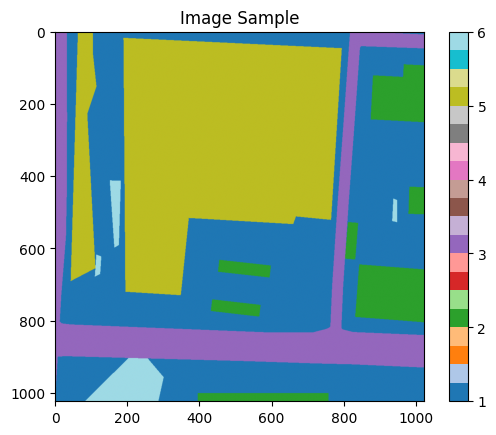

In [21]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

# Maskeyi yükle
mask_img = Image.open(first_mask_path)
mask_np = np.array(mask_img)

# Resmi yükle
image_img = Image.open(first_img_path)
image_np = np.array(image_img)

# Benzersiz sınıf ID'lerini yazdır
print("Sınıf ID'leri:", np.unique(mask_np))


# Görsel olarak göster
plt.imshow(mask_np, cmap='tab20')
plt.title("Mask Sample")
plt.title("Image Sample")
plt.colorbar()
plt.show()


Maskedeki sınıf ID'leri: [1 2 3 5 6]


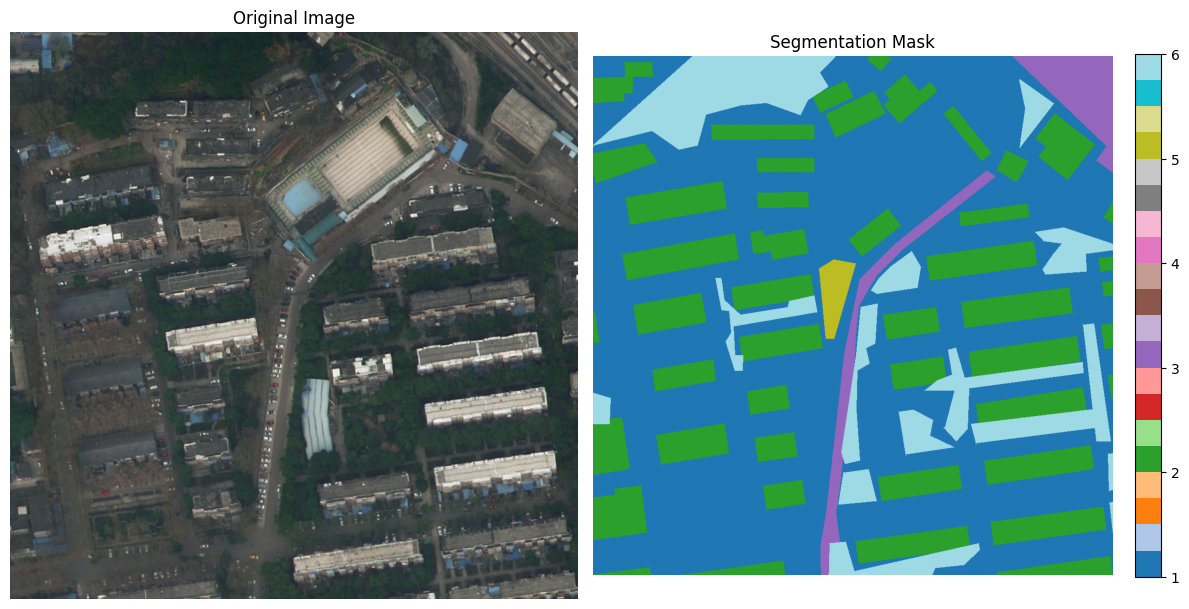

In [22]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

# Dosya yollarını ayarla
image_dir = '/content/loveda-dataset/Train/Train/Urban/images_png'
mask_dir = '/content/loveda-dataset/Train/Train/Urban/masks_png'

# İlk dosyayı seç
image_files = sorted(os.listdir(image_dir))
mask_files = sorted(os.listdir(mask_dir))

first_img_path = os.path.join(image_dir, image_files[2])
first_mask_path = os.path.join(mask_dir, mask_files[2])

# Görüntü ve maske yükle
image_img = Image.open(first_img_path).convert("RGB")
image_np = np.array(image_img)

mask_img = Image.open(first_mask_path)
mask_np = np.array(mask_img)

# Benzersiz sınıf ID'lerini yazdır
print("Maskedeki sınıf ID'leri:", np.unique(mask_np))

# Görsel olarak yan yana göster
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(image_np)
axs[0].set_title("Original Image")
axs[0].axis('off')

im = axs[1].imshow(mask_np, cmap='tab20')
axs[1].set_title("Segmentation Mask")
axs[1].axis('off')

# Colorbar sadece maske için
fig.colorbar(im, ax=axs[1], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()


8 batch size
3 Kanal sayısı (RGB için 3)
H Height
W Weight


In [23]:
images, masks = next(iter(train_loader))
print(images.shape)  # e.g., torch.Size([8, 3, H, W])
print(masks.shape)   # e.g., torch.Size([8, 1, H, W])


torch.Size([8, 3, 256, 256])
torch.Size([8, 256, 256])


In [24]:
class LoveDAClassNames:
    def __init__(self):
        self.classes = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture",
        }

    def get_class_name(self, class_id):
        return self.classes.get(class_id, "Unknown")

    def print_all_classes(self):
        for class_id, class_name in self.classes.items():
            print(f"Class ID {class_id}: {class_name}")

# Kullanımı:
labels = LoveDAClassNames()
labels.print_all_classes()

print(labels.get_class_name(3))  # Output: Water


Class ID 0: Background
Class ID 1: Building
Class ID 2: Road
Class ID 3: Water
Class ID 4: Barren
Class ID 5: Forest
Class ID 6: Agriculture
Water


In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as T
from PIL import Image
import os


In [26]:
print(torch.max(masks), torch.min(masks))
print(outputs.shape)  # [B, 7, H, W] olmalı!
print(masks.dtype)  # torch.int64 olmalı
print(masks.min(), masks.max())  # Değerler 0 ile 6 arasında olmalı

masks = masks.long()
print(masks.dtype)  # torch.int64 olmalı


tensor(6) tensor(0)
torch.Size([4, 7, 256, 256])
torch.int64
tensor(0) tensor(6)
torch.int64


In [27]:
# === UNET_MODEL_START ===

class DoubleConv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.conv(x)

class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()
        self.dconv_down1 = DoubleConv(3, 64)
        self.dconv_down2 = DoubleConv(64, 128)
        self.dconv_down3 = DoubleConv(128, 256)
        self.dconv_down4 = DoubleConv(256, 512)

        self.maxpool = nn.MaxPool2d(2)
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

        self.dconv_up3 = DoubleConv(256 + 512, 256)
        self.dconv_up2 = DoubleConv(128 + 256, 128)
        self.dconv_up1 = DoubleConv(128 + 64, 64)

        self.conv_last = nn.Conv2d(64, n_classes, 1)

    def forward(self, x):
        # Encoder
        conv1 = self.dconv_down1(x)
        x = self.maxpool(conv1)

        conv2 = self.dconv_down2(x)
        x = self.maxpool(conv2)

        conv3 = self.dconv_down3(x)
        x = self.maxpool(conv3)

        x = self.dconv_down4(x)

        # Decoder
        x = self.upsample(x)
        x = torch.cat([x, conv3], dim=1)
        x = self.dconv_up3(x)

        x = self.upsample(x)
        x = torch.cat([x, conv2], dim=1)
        x = self.dconv_up2(x)

        x = self.upsample(x)
        x = torch.cat([x, conv1], dim=1)
        x = self.dconv_up1(x)

        out = self.conv_last(x)
        return out
# === UNET_MODEL_END ===

In [28]:
import os
# The path variable was printed in the output of cell T_LW-4fIE5yU
# If you have rerun cell T_LW-4fIE5yU, please update the path variable accordingly.
path = '/root/.cache/kagglehub/datasets/mohammedjaveed/loveda-dataset/versions/1'
print("Contents of the downloaded dataset directory:")
print(os.listdir(path))

Contents of the downloaded dataset directory:


FileNotFoundError: [Errno 2] No such file or directory: '/root/.cache/kagglehub/datasets/mohammedjaveed/loveda-dataset/versions/1'

In [29]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, jaccard_score
import numpy as np

def calculate_metrics(preds, targets, num_classes):
    preds = preds.cpu().numpy().flatten()
    targets = targets.cpu().numpy().flatten()

    # Precision, F1, Accuracy: macro average
    precision = precision_score(targets, preds, average='macro', zero_division=0)
    f1 = f1_score(targets, preds, average='macro', zero_division=0)
    acc = accuracy_score(targets, preds)
    iou = jaccard_score(targets, preds, average='macro', zero_division=0)

    return precision, f1, acc, iou


In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(n_classes=7)
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)
num_classes = 7

patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation aşaması
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)
            loss = criterion(val_outputs, val_masks)
            val_loss += loss.item()
    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping ve best val loss kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_model.pth")  # En iyi modeli kaydet
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch [1/50], Train Loss: 1.4802, Val Loss: 1.2917
Epoch [2/50], Train Loss: 1.2796, Val Loss: 1.1792
Epoch [3/50], Train Loss: 1.1675, Val Loss: 1.1106
Epoch [4/50], Train Loss: 1.0994, Val Loss: 0.9944
Epoch [5/50], Train Loss: 1.0406, Val Loss: 0.9631
Epoch [6/50], Train Loss: 0.9804, Val Loss: 0.9406
Epoch [7/50], Train Loss: 0.9475, Val Loss: 0.8660
Epoch [8/50], Train Loss: 0.9137, Val Loss: 0.8679
Epoch [9/50], Train Loss: 0.8814, Val Loss: 0.8446
Epoch [10/50], Train Loss: 0.8650, Val Loss: 0.8507
Epoch [11/50], Train Loss: 0.8348, Val Loss: 0.8314
Epoch [12/50], Train Loss: 0.8291, Val Loss: 0.8214
Epoch [13/50], Train Loss: 0.7985, Val Loss: 0.7932
Epoch [14/50], Train Loss: 0.7913, Val Loss: 0.8312
Epoch [15/50], Train Loss: 0.7730, Val Loss: 0.7541
Epoch [16/50], Train Loss: 0.7438, Val Loss: 0.7791
Epoch [17/50], Train Loss: 0.7276, Val Loss: 0.8232
Epoch [18/50], Train Loss: 0.7274, Val Loss: 0.7689
Epoch [19/50], Train Loss: 0.7198, Val Loss: 0.7724
Epoch [20/50], Train 

In [31]:
# Eğitim sonrası model performansını değerlendirme
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # [B, C, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

# Tüm batch'leri birleştir
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Metrikleri hesapla
precision, f1, acc, iou = calculate_metrics(all_preds, all_targets, num_classes)

print("\n=== Eğitim Sonu Genel Metrikler ===")
print(f"Accuracy :  {acc:.4f}")
print(f"F1 Score :  {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"IoU      :  {iou:.4f}")



=== Eğitim Sonu Genel Metrikler ===
Accuracy :  0.8330
F1 Score :  0.8417
Precision:  0.8439
IoU      :  0.7333


In [32]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)  # [B, n_classes, H, W]
        preds = torch.argmax(outputs, dim=1)  # [B, H, W]

        # İlk örneği alalım
        img = images[2].cpu()
        mask = masks[2].cpu()
        pred = preds[2].cpu()

        # Görüntüyü normalize edilmiş halinden orijinale döndür (denormalize)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = img * std + mean
        img = img.clamp(0,1)

        # Maskeleri numpy array’e çevir
        mask = mask.numpy()
        pred = pred.numpy()

        # Renk paleti ve etiketler
        COLOR_MAP = {
          0: (255, 255, 255),   # Background
          1: (255, 0, 0),       # Building
          2: (255, 255, 0),     # Road
          3: (0, 0, 255),       # Water
          4: (159, 129, 183),   # Barren
          5: (0, 255, 0),       # Forest
          6: (255, 195, 128),   # Agricultural
          255: (0, 0, 0),       # IGNORE — siyah
        }



        labels = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture",
            255: "IGNORE"
        }

        # Renkli maske oluşturucu
        def label_to_color(mask):
            h, w = mask.shape
            color_mask = np.zeros((h, w, 3), dtype=np.uint8)
            for class_id, color in COLOR_MAP.items():
               color_mask[mask == class_id] = color
            return color_mask

        color_mask = label_to_color(mask)
        color_pred = label_to_color(pred)

        # Görselleri göster
                # Görselleri göster
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img.permute(1,2,0))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(color_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(color_pred)
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        # --- RENKLİ LEGEND BURADA EKLENİYOR ---
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(facecolor=np.array(COLOR_MAP[class_id]) / 255.0, label=label)
            for class_id, label in labels.items()
        ]


        axs[2].legend(handles=legend_elements,
                      loc='lower right',
                      bbox_to_anchor=(1.5, 0),
                      title="Classes",
                      fontsize=10,
                      title_fontsize=12,
                      frameon=True)

        plt.tight_layout()
        plt.show()


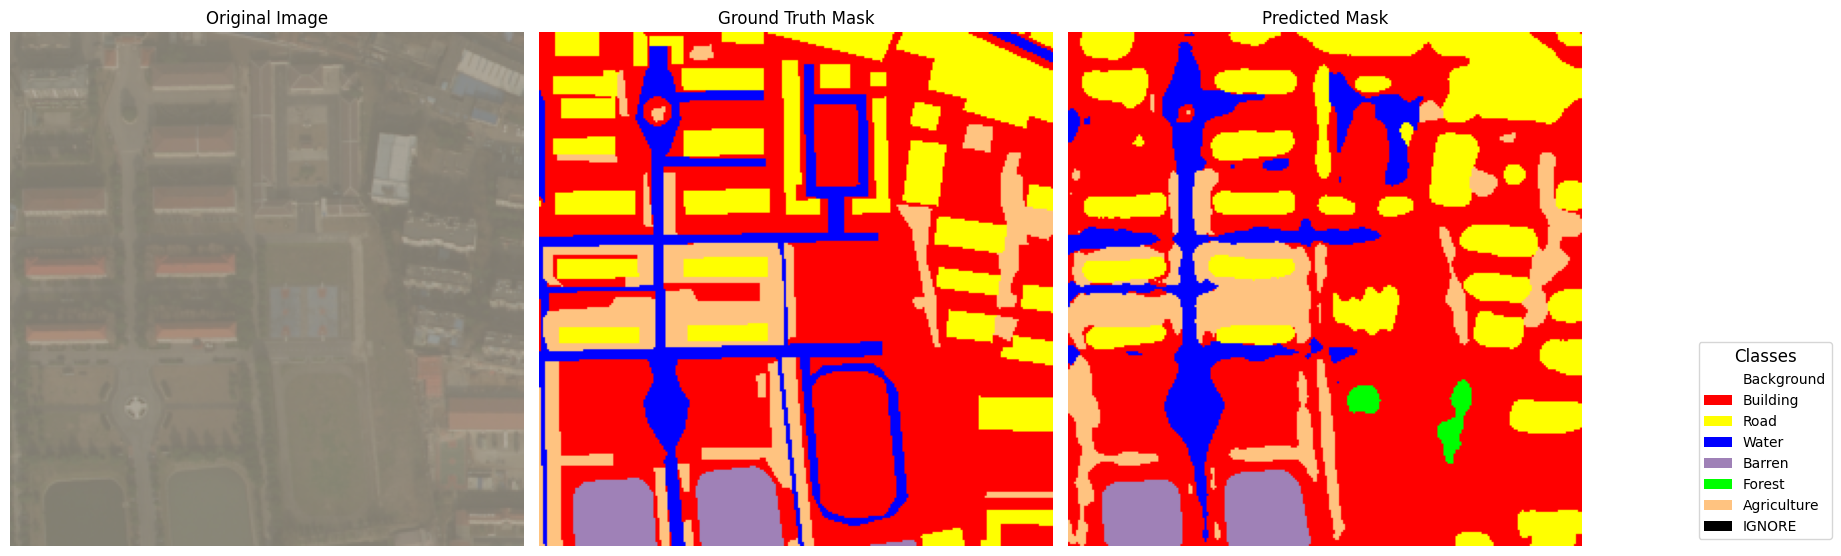

In [33]:
visualize_prediction(model, train_loader, device)


FCN

In [34]:
import torchvision.models.segmentation as models


In [35]:
from torchvision.models.segmentation import fcn_resnet50

# Modeli yükle, pretrained=False (ImageNet değil)
fcn_model = fcn_resnet50(pretrained=False, num_classes=7)  # 7 sınıf
fcn_model = fcn_model.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 207MB/s]


In [36]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(fcn_model.parameters(), lr=1e-4)


In [38]:
num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_loss = running_loss / len(train_loader)

    # Validation aşaması
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)

            val_outputs = model(val_images)['out']
            loss = criterion(val_outputs, val_masks)
            val_loss += loss.item()

    val_loss /= len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    # Early stopping kontrolü
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        epochs_no_improve = 0
        # Modeli kaydetmek istersen burada yapabilirsin
        torch.save(model.state_dict(), 'best_model.pth')
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            break


Epoch [1/50], Train Loss: 1.1020, Val Loss: 1.0016
Epoch [2/50], Train Loss: 0.8231, Val Loss: 1.0590
Epoch [3/50], Train Loss: 0.6967, Val Loss: 0.7637
Epoch [4/50], Train Loss: 0.6099, Val Loss: 0.7187
Epoch [5/50], Train Loss: 0.5492, Val Loss: 0.7592
Epoch [6/50], Train Loss: 0.5019, Val Loss: 0.6973
Epoch [7/50], Train Loss: 0.4566, Val Loss: 0.7137
Epoch [8/50], Train Loss: 0.4165, Val Loss: 0.7109
Epoch [9/50], Train Loss: 0.3856, Val Loss: 0.6954
Epoch [10/50], Train Loss: 0.3553, Val Loss: 0.7210
Epoch [11/50], Train Loss: 0.3301, Val Loss: 0.7272
Epoch [12/50], Train Loss: 0.3419, Val Loss: 0.7537
Epoch [13/50], Train Loss: 0.3068, Val Loss: 0.7154
Epoch [14/50], Train Loss: 0.2808, Val Loss: 0.7301
Early stopping triggered after 14 epochs.


In [39]:
# Değerlendirme (sadece eğitim sonunda)
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # FCN çıktısı
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

# Birleştir
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Metrikleri hesapla
precision, f1, acc, iou = calculate_metrics(all_preds, all_targets, num_classes)

print("\n=== Eğitim Sonu Genel Metrikler (FCN) ===")
print(f"Accuracy :  {acc:.4f}")
print(f"F1 Score :  {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"IoU      :  {iou:.4f}")



=== Eğitim Sonu Genel Metrikler (FCN) ===
Accuracy :  0.8976
F1 Score :  0.9067
Precision:  0.8955
IoU      :  0.8320


In [40]:
def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # FCN için yine ['out']
        preds = torch.argmax(outputs, dim=1)

         # İlk örneği alalım
        img = images[2].cpu()
        mask = masks[2].cpu()
        pred = preds[2].cpu()

        # Görüntüyü normalize edilmiş halinden orijinale döndür (denormalize)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = img * std + mean
        img = img.clamp(0,1)

        # Maskeleri numpy array’e çevir
        mask = mask.numpy()
        pred = pred.numpy()

        # Renk paleti ve etiketler
        palette = {
            0: [255, 255, 255],     # Background - beyaz
            1: [128, 0, 0],         # Building - koyu kırmızı    Background
            2: [255, 255, 0],       # Road - sarı                Building olucak
            3: [0, 0, 128],         # Water - koyu mavi          Yol
            4: [128, 64, 128],      # Barren - morumsu
            5: [0, 128, 0],         # Forest - yeşil
            6: [189, 183, 107]      # Agriculture - bozkır rengi
        }

        labels = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture"
        }

        # Renkli maske oluşturucu
        def label_to_color(mask):
            h, w = mask.shape
            color_mask = np.zeros((h, w, 3), dtype=np.uint8)
            for k, v in palette.items():
                color_mask[mask == k] = v
            return color_mask

        color_mask = label_to_color(mask)
        color_pred = label_to_color(pred)

        # Görselleri göster
                # Görselleri göster
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img.permute(1,2,0))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(color_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(color_pred)
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        # --- RENKLİ LEGEND BURADA EKLENİYOR ---
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(facecolor=np.array(color)/255.0, label=label)
            for label, color in zip(labels.values(), palette.values())
        ]

        axs[2].legend(handles=legend_elements,
                      loc='lower right',
                      bbox_to_anchor=(1.5, 0),
                      title="Classes",
                      fontsize=10,
                      title_fontsize=12,
                      frameon=True)

        plt.tight_layout()
        plt.show()



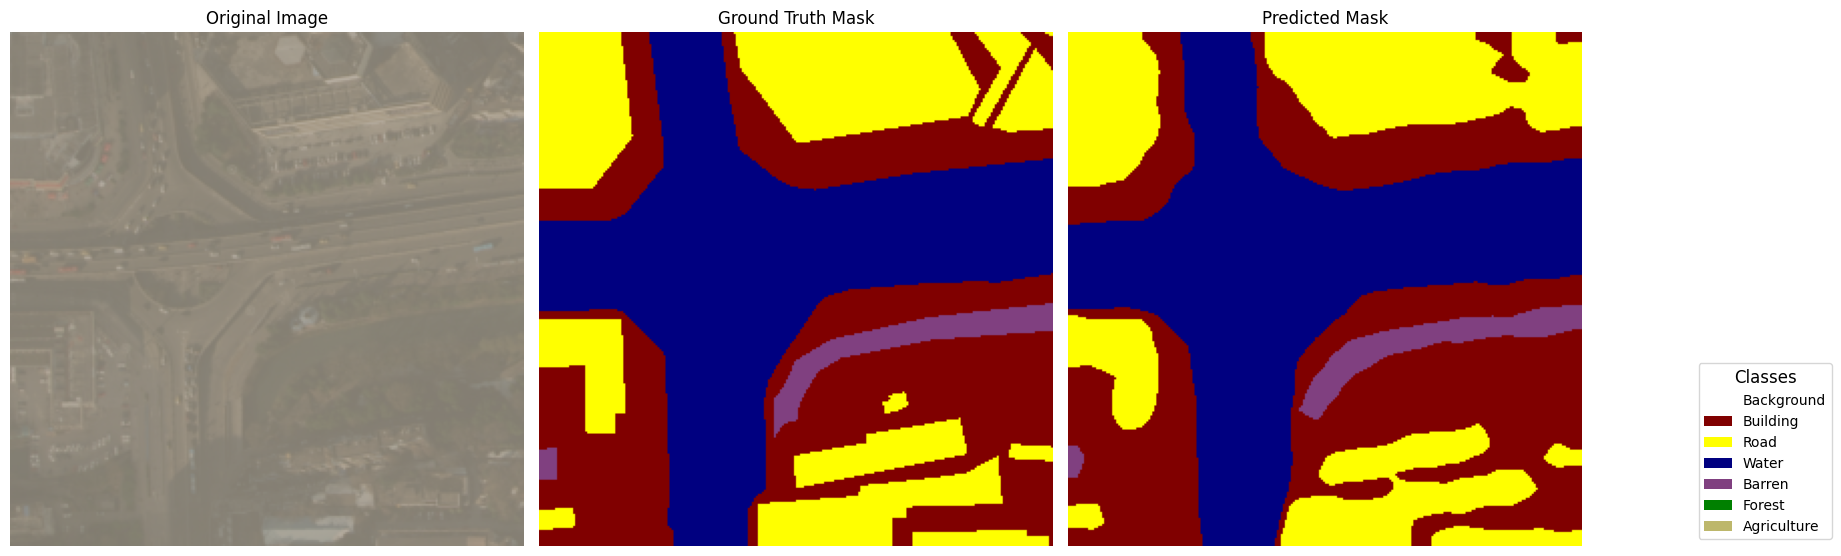

In [41]:
visualize_prediction(model, train_loader, device)


FPN
deeplab


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.models.segmentation import deeplabv3_resnet50

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Modeli oluştur
model = deeplabv3_resnet50(pretrained=False, num_classes=7)
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

num_epochs = 50
patience = 5
best_val_loss = float('inf')
epochs_no_improve = 0

for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        running_train_loss += loss.item()

    avg_train_loss = running_train_loss / len(train_loader)

    model.eval()
    running_val_loss = 0.0
    with torch.no_grad():
        for val_images, val_masks in val_loader:
            val_images = val_images.to(device)
            val_masks = val_masks.to(device)
            val_outputs = model(val_images)['out']
            val_loss = criterion(val_outputs, val_masks)
            running_val_loss += val_loss.item()

    avg_val_loss = running_val_loss / len(val_loader)

    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Early stopping kontrolü
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(model.state_dict(), "best_deeplab_model.pth")  # En iyi modeli kaydet
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= patience:
            print("Early stopping triggered")
            break


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Epoch [1/50], Train Loss: 1.2320, Val Loss: 0.9962
Epoch [2/50], Train Loss: 0.8712, Val Loss: 0.8428
Epoch [3/50], Train Loss: 0.7386, Val Loss: 0.7442
Epoch [4/50], Train Loss: 0.6516, Val Loss: 0.7409
Epoch [5/50], Train Loss: 0.5789, Val Loss: 0.7237
Epoch [6/50], Train Loss: 0.5178, Val Loss: 0.7080
Epoch [7/50], Train Loss: 0.4738, Val Loss: 0.6965
Epoch [8/50], Train Loss: 0.4710, Val Loss: 0.6737
Epoch [9/50], Train Loss: 0.4221, Val Loss: 0.6741
Epoch [10/50], Train Loss: 0.3819, Val Loss: 0.7077


In [ ]:
# Değerlendirme (sadece eğitim sonunda)
model.eval()
all_preds = []
all_targets = []

with torch.no_grad():
    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # FPN
        preds = torch.argmax(outputs, dim=1)

        all_preds.append(preds.cpu())
        all_targets.append(masks.cpu())

# Birleştir
all_preds = torch.cat(all_preds, dim=0)
all_targets = torch.cat(all_targets, dim=0)

# Metrikleri hesapla
precision, f1, acc, iou = calculate_metrics(all_preds, all_targets, num_classes)

print("\n=== Eğitim Sonu Genel Metrikler (FPN) ===")
print(f"Accuracy :  {acc:.4f}")
print(f"F1 Score :  {f1:.4f}")
print(f"Precision:  {precision:.4f}")
print(f"IoU      :  {iou:.4f}")


In [ ]:
def visualize_prediction(model, dataloader, device):
    model.eval()
    with torch.no_grad():
        images, masks = next(iter(dataloader))
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)['out']  # FPN için yine ['out']
        preds = torch.argmax(outputs, dim=1)

         # İlk örneği alalım
        img = images[2].cpu()
        mask = masks[2].cpu()
        pred = preds[2].cpu()

        # Görüntüyü normalize edilmiş halinden orijinale döndür (denormalize)
        mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
        std = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
        img = img * std + mean
        img = img.clamp(0,1)

        # Maskeleri numpy array’e çevir
        mask = mask.numpy()
        pred = pred.numpy()

        # Renk paleti ve etiketler
        palette = {
            0: [255, 255, 255],     # Background - beyaz
            1: [128, 0, 0],         # Building - koyu kırmızı    Background
            2: [255, 255, 0],       # Road - sarı                Building olucak
            3: [0, 0, 128],         # Water - koyu mavi          Yol
            4: [128, 64, 128],      # Barren - morumsu
            5: [0, 128, 0],         # Forest - yeşil
            6: [189, 183, 107]      # Agriculture - bozkır rengi
        }

        labels = {
            0: "Background",
            1: "Building",
            2: "Road",
            3: "Water",
            4: "Barren",
            5: "Forest",
            6: "Agriculture"
        }

        # Renkli maske oluşturucu
        def label_to_color(mask):
            h, w = mask.shape
            color_mask = np.zeros((h, w, 3), dtype=np.uint8)
            for k, v in palette.items():
                color_mask[mask == k] = v
            return color_mask

        color_mask = label_to_color(mask)
        color_pred = label_to_color(pred)

        # Görselleri göster
                # Görselleri göster
        fig, axs = plt.subplots(1, 3, figsize=(18, 6))

        axs[0].imshow(img.permute(1,2,0))
        axs[0].set_title("Original Image")
        axs[0].axis('off')

        axs[1].imshow(color_mask)
        axs[1].set_title("Ground Truth Mask")
        axs[1].axis('off')

        axs[2].imshow(color_pred)
        axs[2].set_title("Predicted Mask")
        axs[2].axis('off')

        # --- RENKLİ LEGEND BURADA EKLENİYOR ---
        from matplotlib.patches import Patch

        legend_elements = [
            Patch(facecolor=np.array(color)/255.0, label=label)
            for label, color in zip(labels.values(), palette.values())
        ]

        axs[2].legend(handles=legend_elements,
                      loc='lower right',
                      bbox_to_anchor=(1.5, 0),
                      title="Classes",
                      fontsize=10,
                      title_fontsize=12,
                      frameon=True)

        plt.tight_layout()
        plt.show()

